<a href="https://colab.research.google.com/github/kingsdigitallab/lwm-davizct/blob/main/LwM_DAVIZCT_01_Explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zooniverse data exploration using [Zoonyper](https://github.com/kingsdigitallab/zoonyper)

## System set up

In [75]:
IN_COLAB = "google.colab" in str(get_ipython())

In [76]:
%%capture
if IN_COLAB:
    !curl -sSL https://install.python-poetry.org | python - && \
        if [ ! -d "zoonyper" ] ; then git clone https://github.com/kingsdigitallab/zoonyper.git; fi && \
        cd zoonyper && \
        git pull && \
        ~/.local/bin/poetry build && \
        pip install dist/zoonyper-0.1.0.tar.gz

In [77]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import base64
import os
import time

import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image
from IPython.display import Markdown as md
from IPython.display import display
from wordcloud import WordCloud

from zoonyper.project import Project

pd.options.plotting.backend = "plotly"

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 12

## Settings

In [78]:
data_path = "data"

if IN_COLAB:
    from google.colab import drive

    # drive.flush_and_unmount()
    drive.mount("/content/drive")
    data_path = "drive/My Drive/Colab Data/lwm/davizct/data"

    !ls -l "drive/My Drive/Colab Data/lwm/davizct/data/downloads" | wc -l

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
26203


In [79]:
def info(msg):
    return md(f">ℹ️ {msg}")


def mm(graph):
    graphbytes = graph.strip().encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url=f"https://mermaid.ink/img/{base64_string}"))

In [80]:
stat = os.stat(os.path.join(data_path, "0_raw", "workflows.csv"))
export_date = time.ctime(stat.st_mtime)

info(f"**This notebook is using data exported on {export_date}**")

>ℹ️ **This notebook is using data exported on Tue Mar 21 13:52:18 2023**

## Project data model

In [81]:
mm(
    """
erDiagram
    workflow ||--|{ annotation : has
    workflow }|--o{ subject_set: has
    subject_set }|--|{ subject: contains
    annotation ||--|| subject: on
    user ||..|{ annotation : makes
    user ||..|{ comment : writes
    tag }|--|{ comment : in
    comment ||--o{ subject : "written about"
"""
)

## Project

In [82]:
project = Project(os.path.join(data_path, "0_raw"))

subjects = project.subjects
# if "subject_id_disambiguated" not in subjects.columns:
#     subjects = project.disambiguate_subjects(os.path.join(data_path, "downloads"))

⚠ Warning: Note that the subject IDs have not yet been
disambiguated. If you want to do so, run the
`.disambiguate_subjects(<download-dir>)` method.


In [83]:
workflows = project.workflows
workflows.head(2)

,display_name,version,active,classifications_count,pairwise,grouped,prioritized,primary_language,first_task,tutorial_subject_id,retired_set_member_subjects_count,tasks,retirement,aggregation,strings,minor_version
workflow_id,,,,,,,,,,,,,,,,
12038,Classify and summarise articles (set 1),1,False,8,False,False,False,en,,,0,{},"{""options"":{""count"":5},""criteria"":""classificat...",{},{},1
12038,Classify and summarise articles (set 1),2,False,8,False,False,False,en,T0,,0,"{""T0"":{""help"":""T0.help"",""type"":""single"",""answe...","{""options"":{""count"":5},""criteria"":""classificat...",{},"{""T0.help"":"""",""T0.question"":""Enter a question.""}",2


In [84]:
meta_df = pd.DataFrame(
    dict(
        source=[
            "workflows",
            "classifications",
            # "subjects",
            "comments",
            "tags",
            "users",
        ],
        count=[
            workflows.shape[0],
            project.classifications.shape[0],
            # subjects["subject_id_disambiguated"].nunique(),
            project.comments.shape[0],
            project.tags["name"].nunique(),
            project.classifications["user_name"].nunique(),
        ],
    )
)

fig = px.bar(
    meta_df, x="count", y="source", color="source", title="Project data overview"
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

## Users

In [85]:
users = (
    project.classifications[["user_name", "user_group_ids"]]
    .value_counts("user_name")
    .reset_index(name="count")
)

info(f"There are **{users.shape[0]}** different users in the project.")

>ℹ️ There are **4938** different users in the project.

In [86]:
fig = px.treemap(
    users,
    path=[px.Constant("Users"), "user_name"],
    values="count",
    title=f"Users contributions to the project",
    height=800,
)
fig.update_traces(marker=dict(cornerradius=5), root_color="lightgrey")
fig.show()

## Workflows

In [87]:
workflows["start_date"] = workflows.apply(
    lambda x: project.classifications[project.classifications["workflow_id"] == x.name][
        "created_at"
    ].min(),
    axis=1,
)
workflows["end_date"] = workflows.apply(
    lambda x: project.classifications[project.classifications["workflow_id"] == x.name][
        "created_at"
    ].max(),
    axis=1,
)

workflows.head(2)

,display_name,version,active,classifications_count,pairwise,grouped,prioritized,primary_language,first_task,tutorial_subject_id,retired_set_member_subjects_count,tasks,retirement,aggregation,strings,minor_version,start_date,end_date
workflow_id,,,,,,,,,,,,,,,,,,
12038,Classify and summarise articles (set 1),1,False,8,False,False,False,en,,,0,{},"{""options"":{""count"":5},""criteria"":""classificat...",{},{},1,2019-09-12,2021-06-21
12038,Classify and summarise articles (set 1),2,False,8,False,False,False,en,T0,,0,"{""T0"":{""help"":""T0.help"",""type"":""single"",""answe...","{""options"":{""count"":5},""criteria"":""classificat...",{},"{""T0.help"":"""",""T0.question"":""Enter a question.""}",2,2019-09-12,2021-06-21


In [88]:
workflows_timeline_df = (
    workflows.reset_index()
    .groupby(["workflow_id", "display_name", "start_date", "end_date", "active"])
    .count()
    .reset_index()
    .sort_values(by="display_name", key=lambda x: x.str.lower())
)

info(
    f"There are **{workflows_timeline_df.shape[0]}** different workflows in the project, "
    f"of which **{workflows_timeline_df[workflows_timeline_df['active'] == True].shape[0]}** are active."
)

>ℹ️ There are **21** different workflows in the project, of which **5** are active.

In [89]:
px.timeline(
    workflows_timeline_df,
    x_start="start_date",
    x_end="end_date",
    y="display_name",
    color="active",
    title="Workflows timeline",
    height=600,
).update_xaxes(rangeslider_visible=True)

### Select a workflow

In [128]:
workflow_options = list(set(workflows["display_name"].sort_values(ascending=True).items()))
workflow_options
# workflow_options = [(name, id) for id, name in workflow_options]

# workflow_widget = widgets.Dropdown(
#     options=workflow_options,
#     value=20921,
#     description="Select a workflow:",
# )
# display(workflow_widget)

# workflow_id = workflow_widget.value
# workflow = workflows.loc[workflow_id]
# workflow_name = workflow["display_name"].iloc[0]

[(23628, "How did the word 'car' change over time and place?"),
 (23457, 'Accident detail: where were accidents reported?'),
 (20042, "What's that machine? Classify it! II"),
 (22858, 'Accident detail: where were accidents reported?'),
 (21001, "Kalle's test workflow"),
 (22513, 'Accident place - type'),
 (16931, 'Find stories about industrial accidents II'),
 (23672, 'Bicycle or motorcycle?'),
 (20436, 'Ad or not'),
 (22514, 'Accident place - draw and type'),
 (12264, 'Find stories about industrial accidents'),
 (12038, 'Classify and summarise articles (set 1)'),
 (20921, 'How did machines change accidents?'),
 (12648, 'Annotate articles'),
 (12194, 'Outline relevant articles (WIP)'),
 (23758, "How did the word 'train' change over time and place?"),
 (16790, "What's that machine? Classify it!"),
 (22885, 'Outline relevant articles'),
 (19348, 'ad or not?'),
 (12051, 'Classify articles (set 2)'),
 (20905, 'Authored or not?'),
 (23681, "How did the word 'coach' change over time and plac

In [103]:
md(f"### *{workflow_name}* workflow")

### *How did machines change accidents?* workflow

#### Classifications

In [104]:
classifications = project.classifications[
    project.classifications["workflow_id"] == workflow_id
]
classifications.head(2)

,user_name,user_ip,workflow_id,workflow_version,created_at,gold_standard,expert,subject_ids,user_logged_in,source,...,subject_selection_state.user_has_finished_workflow,seen_before,seconds,T1,T0,T3,T2,T4,T6,T5
classification_id,,,,,,,,,,,,,,,,,,,,,
397282864,130db9e1,2eb8c8,20921,1.1,2022-02-16,False,False,72990895,True,api,...,False,,56,,There is only one article on the image and it ...,,"A transport (road, rail, water, etc) accident",,,
397283385,130db9e1,bfcc1a,20921,1.1,2022-02-16,False,False,72990886,True,api,...,False,,168,,There are no relevant articles on this image,,,,,


In [105]:
classifications_by_day = classifications.value_counts("created_at").reset_index(
    name="count"
)
classifications_by_day = classifications_by_day.sort_values("created_at")
classifications_by_day["cumulative_count"] = classifications_by_day["count"].cumsum()
classifications_by_day = classifications_by_day.sort_values("created_at")

In [106]:
fig = classifications_by_day.plot.line(
    x="created_at", y="count", title="Classifications per day"
)
fig.show()

In [107]:
info(
    f"The workflow *{workflow_name}* has been worked on during **{classifications_by_day.shape[0]}** days."
)

>ℹ️ The workflow *How did machines change accidents?* has been worked on during **157** days.

In [108]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=classifications_by_day["created_at"],
        y=classifications_by_day["count"],
        mode="lines",
        name="Count",
    )
)

fig.add_trace(
    go.Scatter(
        x=classifications_by_day["created_at"],
        y=classifications_by_day["cumulative_count"],
        mode="lines",
        name="Cumulative Count",
        fill="tozeroy",
    )
)

fig.update_xaxes(rangeslider_visible=True).update_yaxes(type="log")

fig.update_layout(
    barmode="group", title="Classifications per day with cummulative count (log scale)"
)

fig.show()

#### Classification by user

In [109]:
classifications_by_user = classifications.value_counts("user_name").reset_index(
    name="count"
)

In [110]:
info(
    f"The workflow *{workflow_name}* has **{classifications_by_user.shape[0]}** different users."
)

>ℹ️ The workflow *How did machines change accidents?* has **1589** different users.

In [111]:
fig = classifications_by_user[classifications_by_user["count"] > 100].plot.bar(
    x="count",
    y="user_name",
    title="Classifications by user (with a minimum of 100 contributions)",
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

In [112]:
fig = px.treemap(
    classifications_by_user[classifications_by_user["count"] > 10],
    path=[px.Constant("Users"), "user_name"],
    values="count",
    color="count",
    color_continuous_scale="Viridis",
    title=f"Users contributions to the workflow '{workflow_name}'",
)
fig.show()

#### Subjects

In [113]:
subjects = subjects[subjects["workflow_id"] == workflow_id]
subjects.head(2)

,project_id,workflow_id,subject_set_id,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at,!page,...,!original_metadata.newspaper title,!original_metadata.!zooniverse_file_md5,!original_metadata.!zooniverse_file_stem,,!issue,!article_id,!textblock_id,newspaper_date,newspaper_place,newspaper_title
subject_id,,,,,,,,,,,,,,,,,,,,,
73320307,9943,20921,102701,{'0': 'https://panoptes-uploads.zooniverse.org...,4,2022-06-02,consensus,2022-02-24,2022-11-09,0003,...,,,,,,,,,,
73320308,9943,20921,102701,{'0': 'https://panoptes-uploads.zooniverse.org...,5,2022-06-10,classification_count,2022-02-24,2022-11-09,0003,...,,,,,,,,,,


In [114]:
fig = px.bar(
    subjects.value_counts("retirement_reason").reset_index(name="count"),
    x="count",
    y="retirement_reason",
    title="Subjects by retirement reason",
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

## Comments

In [115]:
# there are names in the comments, is that a problem
comments = project.comments
comments["focus_type"] = comments["focus_type"].fillna("")
comments["len"] = comments["body"].str.len()
comments.head()

,body,focus_id,focus_type,user_id,user_login,created_at,len
comment_id,,,,,,,
1832647,To get things started I've collected comments ...,0,,1926730,miaridge,2019-09-16,443
1833213,"Image zoom! If you have a tall column of text,...",0,,1926730,miaridge,2019-09-16,162
1833591,Other requests / comments from Andre and Emma:...,0,,1926730,miaridge,2019-09-16,830
1834282,"Hi Mia, replying to your email here... If I re...",0,,1928640,andrepiza,2019-09-17,476
1837199,On the image zoom thing - it turns out that (s...,0,,1926730,miaridge,2019-09-19,561


In [116]:
fig = px.bar(
    comments.value_counts("focus_type").reset_index(name="count"),
    y="focus_type",
    x="count",
    title="Comments by focus",
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

## Tags

In [117]:
tags = project.tags.value_counts("name").reset_index(name="count")

fig = px.bar(
    tags[tags["count"] > 4],
    x="count",
    y="name",
    title="Tags used 5 times or more",
    height=500,
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

In [118]:
def show_wordcloud(words):
    wordcloud = WordCloud(background_color="white", width=4096, height=2304).fit_words(
        words
    )

    plt.axis("off")
    plt.imshow(wordcloud, interpolation="quadric")
    plt.show()

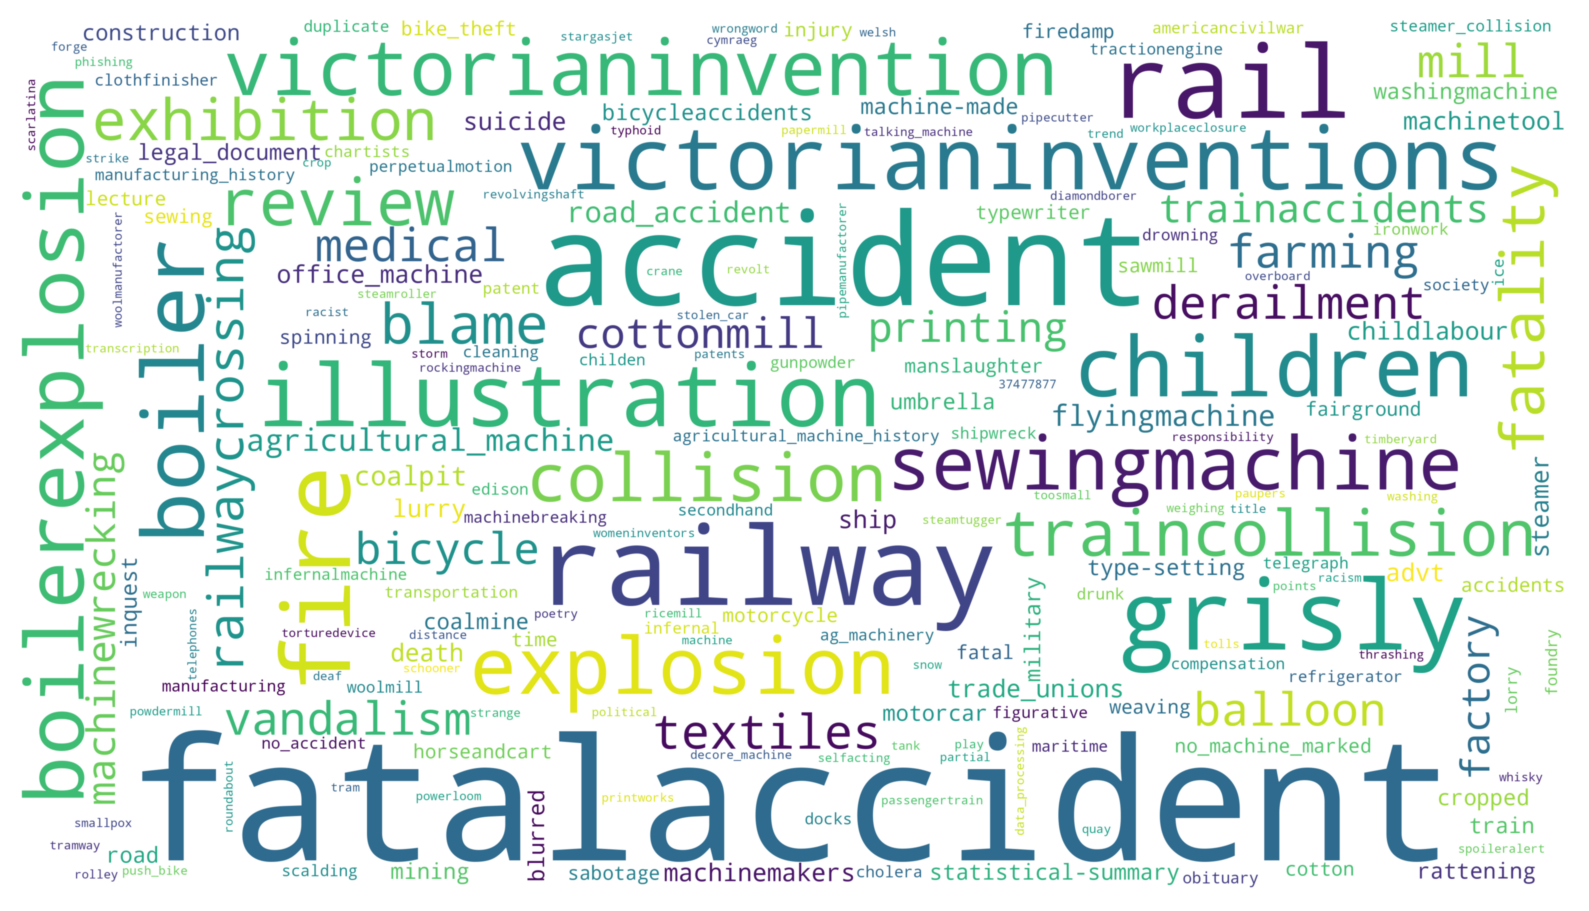

In [119]:
show_wordcloud(tags.set_index("name")["count"].to_dict())